In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skfuzzy as fuzz
from sklearn.metrics import fowlkes_mallows_score
import math
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import random
import re

# wczytanie danych

In [2]:
pd.options.display.max_rows = 6

ratings = pd.read_csv(Path('..','..','res','data','ratings.csv'))
users = pd.read_csv(Path('..','..','res','data','users.csv'))
movies = pd.read_csv(Path('..','..','res','data','movies.csv'))


# zmiana napisów na liczby
label_encoder = LabelEncoder()
users['gender'] = label_encoder.fit_transform(users['gender'])
users['occupation'] = label_encoder.fit_transform(users['occupation'])

"""
matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
matrix = matrix.fillna(0)

train_set, test_set = train_test_split(matrix, test_size=0.2)#, random_state=42)

users_train = users[~users['user_id'].isin(test_set.index.to_list())]
users_test = users[users['user_id'].isin(test_set.index.to_list())]

items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]
#jeżeli jakiś przedmiot wpadnie tylko do zbioru testowego to "wypada" z dalszych analiz
#ponieważ ma przed wejściem zimnych userów sume ratingów = 0, więc zgodnie z moją metodą
#nie zostanie zarekomendowany w topN filmów
items_test = ratings[ratings['user_id'].isin(test_set.index.to_list())]

train_set.to_csv(Path('..','..','outputs','train_set.csv'), index = False)
test_set.to_csv(Path('..','..','outputs','test_set.csv'), index = False)

all_users_clustered = users_train_clusters = cluster_users(users_train.copy(), users_test.copy())
users_train_clustered = all_users_clustered[0]
users_test_clustered = all_users_clustered[1]
#items_clustered = cluster_items(items_train)
#items_clustered.to_csv(Path('..','..','outputs','items_clustered3.csv'), index=False)
items_clustered = items_train.copy()
items_clustered['cluster'] = 1
"""

'\nmatrix = ratings.pivot(index=\'user_id\', columns=\'movie_id\', values=\'rating\')\nmatrix = matrix.fillna(0)\n\ntrain_set, test_set = train_test_split(matrix, test_size=0.2)#, random_state=42)\n\nusers_train = users[~users[\'user_id\'].isin(test_set.index.to_list())]\nusers_test = users[users[\'user_id\'].isin(test_set.index.to_list())]\n\nitems_train = ratings[~ratings[\'user_id\'].isin(test_set.index.to_list())]\n#jeżeli jakiś przedmiot wpadnie tylko do zbioru testowego to "wypada" z dalszych analiz\n#ponieważ ma przed wejściem zimnych userów sume ratingów = 0, więc zgodnie z moją metodą\n#nie zostanie zarekomendowany w topN filmów\nitems_test = ratings[ratings[\'user_id\'].isin(test_set.index.to_list())]\n\ntrain_set.to_csv(Path(\'..\',\'..\',\'outputs\',\'train_set.csv\'), index = False)\ntest_set.to_csv(Path(\'..\',\'..\',\'outputs\',\'test_set.csv\'), index = False)\n\nall_users_clustered = users_train_clusters = cluster_users(users_train.copy(), users_test.copy())\nusers_tra

In [3]:
def cluster_items(items_info):
    data_to_cluster = items_info['rating'].to_numpy()
    data_to_cluster = data_to_cluster.reshape(-1,1)
    K_FCM = 100
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_to_cluster.T, K_FCM, 2, error=0.005, maxiter=1000)
    clusters = np.argmax(u, axis=0)
    items_info['cluster'] = clusters
    return(items_info)


def cluster_items2(items_info):
    data_to_cluster = items_info[['rating', 'user_id', 'movie_id']].to_numpy()
    print(items_info.shape, data_to_cluster.shape)
    data_to_cluster = data_to_cluster.reshape(-1,3)
    print(data_to_cluster.shape)
    K_FCM = 100
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_to_cluster.T, K_FCM, 2, error=0.005, maxiter=1000)
    clusters = np.argmax(u, axis=0)
    print(len(clusters))
    items_info['cluster'] = clusters
    return(items_info)

def cluster_items_SVD(ratings_df):
    ratings_matrix = ratings_df.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)
    svd = TruncatedSVD(n_components=10)  # Dobra liczba komponentów dobrane empirycznie
    matrix_reduced = svd.fit_transform(ratings_matrix)
    kmeans = KMeans(n_clusters=10)  # Dobra liczba klastrów dobrane empirycznie
    kmeans.fit(matrix_reduced)
    
    clust_dict = {'movie_id':ratings_matrix.index.values,
              'cluster': kmeans.labels_}
    clust_df = pd.DataFrame(clust_dict, columns=clust_dict.keys())   
    
    rtg_cl_merged = pd.merge(ratings_df, clust_df, on='movie_id', how='left')
    rtg_cl_merged.to_csv(Path('..','..','outputs','train_items_svd.csv'), index = False)
    return rtg_cl_merged

def no_year(row):
    row['title'] = re.sub(r'\s\(\d{4}\)', '', row['title'])
    return row

def cluster_movies(movies_df, ratings_df):
    
    data_to_clustering = movies_df.drop(['release_date', 'video_release_date','IMDb_URL'], axis = 1)
    data_to_clustering = data_to_clustering.apply(lambda row: no_year(row), axis = 1)        
    
    features = data_to_clustering  # Wybierz odpowiednie cechy

    label_encoder = LabelEncoder()
    features['title'] = label_encoder.fit_transform(features['title'])

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Wybierz optymalną liczbę klastrów
    optimal_clusters = 15  # Załóżmy, że optymalna liczba klastrów wynosi 3

    # Wykorzystaj algorytm k-means
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    data_to_clustering['cluster'] = kmeans.fit_predict(features_scaled)

    merged = pd.merge(ratings_df, data_to_clustering[['movie_id','cluster']], how='left', on='movie_id')
    return merged

def cluster_movies_1(ratings_df):
    ratings_df['cluster'] = 1
    return ratings_df

In [4]:
def cluster_users(users_info, test_users_info):
    data_to_cluster = users_info[['age','gender','occupation']]
    #kmode = KModes(n_clusters=5, init = "random", n_init = 5, verbose=1, random_state=42) 
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, random_state=42) 
    clusters = kmode.fit_predict(data_to_cluster) 
    users_info['cluster'] = clusters
    data_to_cluster_test = test_users_info[['age','gender','occupation']]
    test_clusters = kmode.predict(data_to_cluster_test)
    test_users_info['cluster'] = test_clusters
    return(users_info, test_users_info)

In [5]:
def find_test_users_indices(ratings):
    """
    1. przerobic oceny na 1
    2. obliczyc ile ocen kazdy wystawił
    3. randomowo wybierac i dodawac do siebie elementy dopoki bedzie 20%
    4. zapisyawac indeksy i dodac do nich 1. jak wiecej ludzi ma ta sama wartosc
        to randomowo wybrac o kogo chodzi
    """
    ratings = pd.read_csv(Path('..','..','res','data','ratings.csv'))
    ratings = ratings.pivot(index='user_id',columns='movie_id',values='rating')
    ratings = ratings.fillna(0)
    ratings_np = ratings.to_numpy()
    array_binary = (ratings_np != 0).astype(int)
    actions_per_user = np.sum(array_binary, axis=1).tolist()
    
    number_of_ratings = 0
    users_indices = []
    while number_of_ratings < 2 * 10**4:
            choosen = random.choice(actions_per_user)
            indices = [index for index, value in enumerate(actions_per_user) if value == choosen]
            index = random.choice(indices) + 1 # +1 bo użytkownicy są numerowani od 1
            if number_of_ratings + choosen < 2.01 * 10**4 and index not in users_indices:
                number_of_ratings += choosen
                users_indices.append(index)
            else:
                number_of_ratings = number_of_ratings
            
    return np.sort(users_indices)

In [6]:
def IP(train_matrix, items_clustered):
    train_numpy = train_matrix.to_numpy()
    #szukanie IPmax
    IP = np.sum(train_numpy, axis = 0) #sumowanie po kolumnach
    IP = IP.reshape(1,-1)
    IPmax = np.amax(IP)
    IPmax_coordinates = np.argmax(IP) + 1 #bo filmy mają indeksy od 1
    item_rating = pd.DataFrame({'rating':IP[0], 'movie_id': train_matrix.columns.to_list()})
    
    #znalezienie filmu o najwyższym IP
    IPmax_movie_id = item_rating[item_rating['rating'] == IPmax]['movie_id'].values[0]
    
    #znalezienie clustra, gdzie znajduje się ten film i pozostałych należących tu filmów
    IPmax_cluster = items_clustered[items_clustered['movie_id'] == IPmax_movie_id].iloc[0,4]#.loc[:,'cluster']
    max_clust_movies = items_clustered[items_clustered['cluster'] == IPmax_cluster]['movie_id'].to_list()
    max_clust_movies = list(set(max_clust_movies))

    #obliczenie IP^
    """print('klaster IPmax:', IPmax_cluster)
    print('filmy z max klastra:', np.array(max_clust_movies))
    print("IPmax:", IPmax)
    print('id IPmax:', IPmax_movie_id)"""
    
    IP_dash = IP[:,np.array(max_clust_movies) - 1] / IPmax
    return(IP_dash, max_clust_movies)

"""IP_dash_movies = IP(train_set, items_clustered)
IP_dashhhh = IP_dash_movies[0]
IP_moviesss = IP_dash_movies[1]"""

'IP_dash_movies = IP(train_set, items_clustered)\nIP_dashhhh = IP_dash_movies[0]\nIP_moviesss = IP_dash_movies[1]'

In [7]:
#def UP_HP(train_test_set, cluster, clust_data, IP_dash, alpha, selected_movies, ratings_matrix):
def UP_HP(train_matrix, test_matrix, test_users_cl, train_users_cl, cluster, IP_dash, alpha, selected_movies, ratings_matrix):    
    
    #utworzenie macierzy, gdzie ratingi dane przez testowych są zerami
    test_set_zero = test_matrix.copy()
    test_set_zero[:] = 0 
    train_and_test = pd.concat([train_matrix, test_set_zero], ignore_index=False)
    train_and_test = train_and_test.sort_index()
    
    concated_users_clustered = pd.concat([train_users_cl,test_users_cl], ignore_index=True).sort_values('user_id')

    #znalezienie użytkowników w danym clustrze
    users_in_cluster = concated_users_clustered[concated_users_clustered['cluster'] == cluster]['user_id'].to_list()
    users_in_cluster = list(set(users_in_cluster))
    
    #macierz ratingów tylko dla tych userów i filmów z clustra z IPmax
    ratings_matrix_cluster = train_and_test.loc[train_and_test.index.isin(users_in_cluster),selected_movies].sort_index()
    ratings_matrix_cluster_np = ratings_matrix_cluster.to_numpy()

    #obliczanie user popularity
    UP = np.sum(ratings_matrix_cluster_np, axis=1) ##sumowanie po wierszach
    UP = UP.reshape(-1,1)
    UPmax = np.amax(UP)
    UPmax_coordinates = np.argmax(UP)
    UP_dash = UP / UPmax
    
    # obliczenie UIP i hybrydy
    UIP = UP_dash / IP_dash
    #wstawienie zer tam gdzie w rzeczywistości uzytkownik treningowy nie ocenił danego filmu
    UIP = np.where(ratings_matrix_cluster == 0, 0, UIP)
    HP = alpha * IP_dash + (1-alpha) * np.sum(UIP,axis = 0).reshape(1,-1)
    return(HP)
    #return np.sum(pd.DataFrame(UIP, index=ratings_matrix_cluster.index, columns=ratings_matrix_cluster.columns).loc[243,9])

"""test_set_zero = test_set.copy()
test_set_zero[:] = 0
concated_users_clustered = pd.concat([us_tr_cl,us_te_cl], ignore_index=True).sort_values('user_id')
train_and_test = pd.concat([train_set, test_set_zero], ignore_index=False)
train_and_test = train_and_test.sort_index()"""

"""UP_HP(train_set, test_set, users_test_clustered, users_train_clustered, 1, IP_dashhhh, 0.5, IP_moviesss, matrix).shape"""

'UP_HP(train_set, test_set, users_test_clustered, users_train_clustered, 1, IP_dashhhh, 0.5, IP_moviesss, matrix).shape'

In [8]:
def HP_for_clust(test_matrix, train_matrix, alpha, ratings_matrix, test_users_cl, train_users_cl, items_cl):

    #zapewnienie prawdiłowej kolejnosci wierszy i kolumn
    train_matrix = train_matrix.sort_index()
    test_matrix = test_matrix.sort_index()
    
    #podział na clustry
    #users_clustered = cluster_users(users_train.copy())
    #items_clustered = cluster_items(items_train.copy())
    
    """users_clustered = pd.read_csv(Path('..','..','outputs','users_train_clustered.csv'))
    #items_clustered = pd.read_csv(Path('..','..','outputs','items_train_clustered.csv'))
    users_clustered['cluster'] = 1
    #przypisanie nowych użytkowników do clustrów
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, random_state = 42)#verbose=1, random_state=42) 
    train_clusters = kmode.fit_predict(users_train)
    test_users_clusters = kmode.predict(users_test)
    test_users_clustered = users_test.copy() ##OCEŃ CZY KOPIOWANIE JEST KONIECZNE
    test_users_clustered['cluster'] = test_users_clusters"""
    
    ### klastrowanie ###
    test_users_clustered = test_users_cl
    test_users_clusters = test_users_clustered['cluster'].values
    aa = items_cl
    #items_clustered = items_cl
    
    ## IP ##
    IP_results = IP(train_matrix, aa)
    IP_dash = IP_results[0]
    movies_from_max_cluster = IP_results[1]
    item_cluster_size = len(movies_from_max_cluster)
    for_test={}
    clust_HP = {}
    for cl in list(set(test_users_clusters)):
        HP = UP_HP(train_matrix, test_matrix, test_users_clustered, train_users_cl, cl, IP_dash, alpha, movies_from_max_cluster, ratings_matrix)[0].tolist()  
        clust_HP[cl] = (movies_from_max_cluster, HP)
        for_test[cl] = HP
    df = pd.DataFrame(for_test)
    df.to_csv('article_test.csv')
    return(clust_HP, test_users_clustered) #słownik [cluster[]: [filmy z clustra gdzie IP_max, HP],
                                            #testowi uzytkownicy z wygenerowanymi klastrami
                                            #liczba filmow w max klastrze

"""z = HP_for_clust(test_matrix, train_matrix, 0.5, ratings_matrix, us_te_cl, us_tr_cl, items_clusters)
len(z[0][1][0]) #długość movies_from_max_cluster
z[0][1][1][-3] #3 od konca wartość z HP"""

'z = HP_for_clust(test_matrix, train_matrix, 0.5, ratings_matrix, us_te_cl, us_tr_cl, items_clusters)\nlen(z[0][1][0]) #długość movies_from_max_cluster\nz[0][1][1][-3] #3 od konca wartość z HP'

In [9]:
def create_matrix_for_generated(test_matrix, train_matrix, alpha, ratings_matrix, test_users_cl, train_users_cl, items_cl):
    HP_and_clust = HP_for_clust(test_matrix, train_matrix, alpha, ratings_matrix, test_users_cl, train_users_cl, items_cl)
    movies_and_HP = HP_and_clust[0] #słownik [cluster]:[filmy do polecenia, HP]
    
    #dataframe testowych uzytkownikow z przypisanymi clustrami
    test_users_with_clusters = HP_and_clust[1]
    #dataframe pokazujący cluster i ilu uzytkowników do niego nalezy
    num_users_in_clust = test_users_with_clusters.groupby('cluster').agg(users_number = ('cluster','size')).reset_index()
    num_users_in_clust_dict = num_users_in_clust.set_index('cluster')['users_number'].to_dict() #liczba użytkowników w każdym clustrze

    #słownik cluster: id uzytkownikow którzy do niego nalezą
    users_per_cluster = test_users_with_clusters.groupby('cluster')['user_id'].apply(list).to_dict() #uzytkownicy (id) w kazdym clustrze

    test_users_dictionary = {'user_id':[],
                         'movie_id':[],
                         'rating':[]}
    
    for cl in users_per_cluster.keys():
        num_of_users = num_users_in_clust_dict[cl]
        num_of_items = len(movies_and_HP[cl][0])

        multiplied_users = users_per_cluster[cl] * num_of_items
        multiplied_users.sort()
        test_users_dictionary['user_id'].extend(multiplied_users)
        #aktualizuję uzytkowników w clustrze powielając ich tyle razy ile jest przedmiotów, 
        #bo każdy musi dany przedmiot mieć oceniony
        users_per_cluster[cl] = multiplied_users

        #powielam przedmioty i oceny tyle razy ilu jest użytkowników
        movies_and_HP[cl] = (movies_and_HP[cl][0] * num_of_users, movies_and_HP[cl][1] * num_of_users)
        
        test_users_dictionary['movie_id'].extend(movies_and_HP[cl][0])
        test_users_dictionary['rating'].extend(movies_and_HP[cl][1])

        test_ratings_HP = pd.DataFrame(test_users_dictionary)
        test_ratings_HP.to_csv(Path('..','..','outputs','test_ratings.csv'), index=False)
        test_ratings_matrix = test_ratings_HP.pivot(index='user_id', columns='movie_id', values='rating')
        test_ratings_matrix = test_ratings_matrix.fillna(0)
        test_ratings_matrix.to_csv(Path('..','..','check','test_mtrx_gen.csv'))

    return test_ratings_matrix

"""create_matrix_for_generated(test_set, train_set, 0.5, matrix, users_test_clustered, users_train_clustered, items_clustered)
"""

'create_matrix_for_generated(test_set, train_set, 0.5, matrix, users_test_clustered, users_train_clustered, items_clustered)\n'

In [10]:
def show_Hu(row):
    #wybieranie id filmów, dla których w zbiorze testowym użytkownik wystawił jakieś oceny
    nonzero = row[row > 0].index
    nonzero_indices = nonzero.values
    row['Hu'] = nonzero_indices.tolist()
    return row

In [11]:
def find_topN_items(users_ratings,N):
    topN = users_ratings.nlargest(N) #N najlepiej ocenianych filmów (rating i indeks) 
                                        #zwraca się od najwiekszej do najmn wartosci
    topN_indices = topN.index #indeksy tych najlepiej ocenianych
    #wyrzucam z topN filmy, dla których wystawiono zero
    top_nonzero_indices = users_ratings[topN_indices][users_ratings[topN_indices] > 0].index
    users_ratings["topN_movies"] = top_nonzero_indices.values
    return users_ratings

In [12]:
def NDCG(row,N):
    generated = row.loc['topN_movies']
    from_test_set = row.loc['Hu']
    #sprawdzenie który n-ty element z TopN został irl oceniony przez użytkownika
    gen_num = len(generated)
    available_n = [index + 1  for index, element in enumerate(generated) if element in from_test_set]
    DCG = sum([1 / math.log(1+n,2) for n in available_n])
    IDCG = sum([1 / math.log(1+n,2) for n in range(1,gen_num+1)])
    NDCG = DCG / IDCG
    row['NDCG'] = NDCG
    return row

In [13]:
def Precision_Recall(row,N):
    generated = row.loc['topN_movies']
    from_test_set = row.loc['Hu']
    
    intersection = sum([1 for element in generated if element in from_test_set])
    N != len(generated)
    Precision = intersection * 100 / len(generated)
    row['Precision'] = Precision
    
    row['Recall'] = intersection * 100 / len(from_test_set)
    return row

In [14]:
def nazwepozniej(test_matrix, train_matrix, alpha, N, ratings_matrix, test_users_cl, train_users_cl, items_cl):
    
    generated = create_matrix_for_generated(test_matrix, train_matrix, alpha, ratings_matrix, test_users_cl, train_users_cl, items_cl)
    test_with_Hu = test_matrix.apply(lambda row: show_Hu(row), axis = 1)
    generated_topN = generated.apply(lambda row: find_topN_items(row, N), axis = 1)
    Hu = test_with_Hu.iloc[:,[-1]].sort_index()
    
    merged = pd.merge(generated_topN, Hu, on='user_id', how = 'left')
    merged = merged.apply(lambda row:  NDCG(row,N),axis = 1)
    merged = merged.apply(lambda row:  Precision_Recall(row,N),axis = 1)
    merged.to_csv('wygenerowane_rekomendacje.csv')
    return(merged)
"""output_final = nazwepozniej(test_set, train_set, 0.5, 50, matrix, users_test_clustered, users_train_clustered, items_clustered)
hu1 = output_final[0]
generated1 = output_final[1]
test_with_hu1 = output_final[2]
generatetopN1 = output_final[3]
merged1 = output_final[4]"""

'output_final = nazwepozniej(test_set, train_set, 0.5, 50, matrix, users_test_clustered, users_train_clustered, items_clustered)\nhu1 = output_final[0]\ngenerated1 = output_final[1]\ntest_with_hu1 = output_final[2]\ngeneratetopN1 = output_final[3]\nmerged1 = output_final[4]'

In [27]:
def main(ratings_data, items_data, users_data, alpha, N):

    matrix = ratings_data.pivot(index='user_id', columns='movie_id', values='rating')
    matrix = matrix.fillna(0)
    data_to_kfold = matrix.index.values
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    NDCG_dict = {'H':[], 'I':[], 'U':[]}
    Precision_dict = {'H':[], 'I':[], 'U':[]}
    Recall_dict = {'H':[], 'I':[], 'U':[]}
    for train_idx, test_idx in kfold.split(data_to_kfold):
        train_users = train_idx + 1
        test_users = test_idx + 1
    
        train_set = matrix[matrix.index.isin(train_users)]
        test_set = matrix[matrix.index.isin(test_users)]
        train_set.to_csv('train_5_last.csv')
        test_set.to_csv('test_5_last.csv')
        #train_set, test_set = train_test_split(matrix, test_size=0.2)#, random_state=42)
        test_set.to_csv(Path('..','..','check','test_mtrx_org.csv'))
        users_train = users_data[~users_data['user_id'].isin(test_set.index.to_list())]
        users_test = users_data[users_data['user_id'].isin(test_set.index.to_list())]

        items_train = ratings_data[~ratings_data['user_id'].isin(test_set.index.to_list())]
        #jeżeli jakiś przedmiot wpadnie tylko do zbioru testowego to "wypada" z dalszych analiz
        #ponieważ ma przed wejściem zimnych userów sume ratingów = 0, więc zgodnie z moją metodą
        #nie zostanie zarekomendowany w topN filmów
        items_test = ratings_data[ratings_data['user_id'].isin(test_set.index.to_list())]
        items_test.to_csv(Path('..','..','check','ratings_test.csv'), index = False)
        train_set.to_csv(Path('..','..','outputs','train_set.csv'), index = False)
        test_set.to_csv(Path('..','..','outputs','test_set.csv'), index = False)

        all_users_clustered = cluster_users(users_train.copy(), users_test.copy())
        users_train_clustered = all_users_clustered[0]
        users_test_clustered = all_users_clustered[1]
        #items_clustered = cluster_items_SVD(items_train.copy())
        #items_clustered = cluster_movies(items_data, items_train)
        items_clustered = cluster_movies_1(items_train)
        items_clustered['cluster'] = items_clustered['cluster'].astype(int)
        final_matrix_Upop = nazwepozniej(test_set, train_set, 0, N, matrix, users_test_clustered, users_train_clustered, items_clustered)
        final_matrix_Hpop = nazwepozniej(test_set, train_set, alpha, N, matrix, users_test_clustered, users_train_clustered, items_clustered)
        final_matrix_Ipop = nazwepozniej(test_set, train_set, 1, N, matrix, users_test_clustered, users_train_clustered, items_clustered)

        for df, model in [(final_matrix_Hpop,'H'),(final_matrix_Ipop,'I'),(final_matrix_Upop,'U')]:
            print(model, df['NDCG'].mean())
            NDCG_dict[model].append(df['NDCG'].mean())
            Precision_dict[model].append(df['Precision'].mean())
            Recall_dict[model].append(df['Recall'].mean())
    NDCG_mean = []
    Precision_mean = []
    Recall_mean = []
    print(NDCG_dict.keys())
    for model in NDCG_dict.keys():
        NDCG_mean.append(sum(NDCG_dict[model]) / len(NDCG_dict[model]))
        Precision_mean.append(sum(Precision_dict[model]) / len(Precision_dict[model]))
        Recall_mean.append(sum(Recall_dict[model]) / len(Recall_dict[model]))
    #return(final_matrix_Hpop, final_matrix_Ipop, final_matrix_Upop)#, test_set, train_set)
    return (NDCG_mean, Precision_mean, Recall_mean)

In [ ]:
all_alpha = [main(ratings, movies, users, alpha, 10) for alpha in np.arange(0,1.1,0.1)]

In [22]:
len(all_alpha[0])

5

In [57]:
def for_various_alpha(ratings, movies, users, N):
    for_all_alpha = [main(ratings, movies, users, alpha, N) for alpha in np.arange(0,1.1,0.1)]
    
    NDCG_values = pd.DataFrame(np.array([for_all_alpha[i][0] for i in range(11)]), columns=['HPop', 'IPop', 'UPop']) #11, bo 11 razy wartość policzono
    NDCG_values.to_csv(Path('..','..','outputs','NDCG_alpha.csv'), index=False)
    Precision_values = pd.DataFrame(np.array([for_all_alpha[i][1] for i in range(11)]), columns=['HPop', 'IPop', 'UPop'])
    Precision_values.to_csv(Path('..','..','outputs','Precision_alpha.csv'), index=False)
    Recall_values = pd.DataFrame(np.array([for_all_alpha[i][2] for i in range(11)]), columns=['HPop', 'IPop', 'UPop'])
    Recall_values.to_csv(Path('..','..','outputs','Recall_alpha.csv'), index=False)

    for df in [NDCG_values, Precision_values, Recall_values]:
        df['alpha'] = np.arange(0,1.1,0.1)
        df = df[['alpha', 'HPop', 'IPop', 'UPop']]
    

In [83]:
for_various_alpha(ratings, movies, users, 10)

c:\Users\wypyc\Desktop\inżynierka\project\Cold-Start-Problem-in-RS\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


I 0.5032333480865583


KeyboardInterrupt: 

In [28]:
def for_various_N(ratings, movies, users):
    for_all_N =[main(ratings, movies, users, 0.6, N) for N in range(1,16)]
    
    NDCG_values = pd.DataFrame(np.array([for_all_N[i][0] for i in range(15)]), columns=['HPop', 'IPop', 'UPop'])
    NDCG_values.to_csv(Path('..','..','outputs','NDCG.csv'), index=False)
    Precision_values = pd.DataFrame(np.array([for_all_N[i][1] for i in range(15)]), columns=['HPop', 'IPop', 'UPop'])
    Precision_values.to_csv(Path('..','..','outputs','Precision.csv'), index=False)
    Recall_values = pd.DataFrame(np.array([for_all_N[i][2] for i in range(15)]), columns=['HPop', 'IPop', 'UPop'])
    Recall_values.to_csv(Path('..','..','outputs','Recall.csv'), index=False)

    for df in [NDCG_values, Precision_values, Recall_values]:
        df['N'] = df.index.values + 1
        df = df[['N', 'HPop', 'IPop', 'UPop']]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
    
    ax1.scatter(NDCG_values['N'], NDCG_values['HPop'], label = 'HPop', color = 'blue')
    ax1.scatter(NDCG_values['N'], NDCG_values['IPop'], label = 'IPop', color = 'red')
    ax1.scatter(NDCG_values['N'], NDCG_values['UPop'], label = 'UPop', color = 'green')
    ax1.legend()
    #ax1.xlabel('N')
    #ax1.ylabel('NDCG@N')
    ax1.grid()
    
    ax2.scatter(Recall_values['HPop'], Precision_values['HPop'], label = 'HPop', color = 'blue', marker = 'o')
    ax2.scatter(Recall_values['UPop'], Precision_values['UPop'], label = 'UPop', color = 'green', marker = 'o')
    ax2.scatter(Recall_values['IPop'], Precision_values['IPop'], label = 'IPop', color = 'red', marker = 'o')
    ax2.legend()
    #ax2.xlabel('Precision')
    #ax2.ylabel('Recall')
    ax2.grid()
    
    plt.tight_layout()  # Dostosuj układ, aby uniknąć nakładania się tytułów i osi
    plt.show()

In [29]:
for_various_N(ratings, movies, users)

C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.6137566137566137
U 0.0


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.005291005291005291
I 0.6666666666666666
U 0.005291005291005291


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.005291005291005291
I 0.5873015873015873
U 0.005291005291005291


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.6329787234042553
U 0.0


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.5904255319148937
U 0.0
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0020468402499182097
I 0.5830540100078405
U 0.0020468402499182097


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.003244165041087082
I 0.6216361811684661
U 0.003244165041087082


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.003244165041087082
I 0.5709268653022416
U 0.003244165041087082


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.5877087140470217
U 0.0


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.573963710330445
U 0.0
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0028080490686626636
I 0.5654284871708172
U 0.0028080490686626636


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002482956222342627
I 0.6160628901566298
U 0.002482956222342627


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002482956222342627
I 0.5660786728634573
U 0.002482956222342627


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0012480817181456292
I 0.5746172875613552
U 0.0012480817181456292


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.5566089124525513
U 0.0
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0032255023809941714
I 0.558431193398725
U 0.0032255023809941714


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.00206550291001112
I 0.6085586321157417
U 0.00206550291001112


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.00206550291001112
I 0.5678677018124846
U 0.00206550291001112


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0010382448138087812
I 0.5584948852176413
U 0.0010382448138087812


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.5551400541221934
U 0.0
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.004884920369053267
I 0.5427813464074743
U 0.004884920369053267


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002488705199925704
I 0.5932738782353751
U 0.002488705199925704


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002488705199925704
I 0.544037669410115
U 0.002488705199925704


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0009020218225362132
I 0.5396536696930667
U 0.0009020218225362132


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0
I 0.5339474120776583
U 0.0
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.005499004906357802
I 0.5390254507291456
U 0.005499004906357802


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0033610757443693065
I 0.5812238703070042
U 0.0033610757443693065


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0027907627574671324
I 0.5407166687244241
U 0.0027907627574671324


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0008047936529223764
I 0.5302193150634792
U 0.0008047936529223764


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.001146693133239478
I 0.5222613972988359
U 0.001146693133239478
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.005964737559793123
I 0.5337529589797687
U 0.005964737559793123


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.003053115685949504
I 0.5764480460103121
U 0.003053115685949504


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002535057879865019
I 0.5328652648217775
U 0.002535057879865019


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0007310540768997098
I 0.5216020242790046
U 0.0007310540768997098


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002503735019224609
I 0.5202216868804853
U 0.002503735019224609
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.005488784078563327
I 0.5278932072499065
U 0.005488784078563327


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0028094937286113914
I 0.5697146194663276
U 0.0028094937286113914


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0044437407347482855
I 0.5291873128662731
U 0.0044437407347482855


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0006727199541693009
I 0.5198783007196466
U 0.0006727199541693009


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0031528287084962173
I 0.5198814238116225
U 0.0031528287084962173
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.005474790089995166
I 0.5174962973042411
U 0.005474790089995166


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002610705862602387
I 0.5649690930847792
U 0.002610705862602387


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.004503689582958259
I 0.5276836959975323
U 0.004503689582958259


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0010014815714272517
I 0.511320948272404
U 0.0010014815714272517


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.003306108344170756
I 0.510194769099529
U 0.003306108344170756
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.005126479629245864
I 0.5185711856045429
U 0.005126479629245864


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.00278122862484658
I 0.5576378378678579
U 0.00278122862484658


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.004217161301887047
I 0.5230611850585912
U 0.004217161301887047


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0009377665244863252
I 0.512292742859488
U 0.0009377665244863252


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0034341795733102455
I 0.5071773107188433
U 0.0034341795733102455
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.004829954040564649
I 0.5121412556811146
U 0.004829954040564649


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0029263990063195613
I 0.5532328055567067
U 0.0029263990063195613


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.003973232460256274
I 0.5166775868763417
U 0.003973232460256274


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0008835242781829394
I 0.5057359774247449
U 0.0008835242781829394


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0035432098807320145
I 0.5003010919495048
U 0.0035432098807320145
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.004854418990335452
I 0.5088297910523818
U 0.004854418990335452


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.002771114307209624
I 0.5499869534292138
U 0.002771114307209624


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0037623992123798373
I 0.513406167825685
U 0.0037623992123798373


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.00111889363106091
I 0.5014800766775653
U 0.00111889363106091


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0033551950956583936
I 0.4920998023300426
U 0.0033551950956583936
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0046163390564619294
I 0.5082669971999741
U 0.0046163390564619294


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.003154191596644224
I 0.5419563203657249
U 0.003154191596644224


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0035778762535102968
I 0.508986044357901
U 0.0035778762535102968


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0013248907869065844
I 0.49592917310333884
U 0.0013248907869065844


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0031906430394602293
I 0.4917046429204554
U 0.0031906430394602293
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.004405767723662282
I 0.5034250061740042
U 0.004405767723662282


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.003010315178493979
I 0.5406458743315739
U 0.003010315178493979


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0034146737326210936
I 0.5108689368184481
U 0.0034146737326210936


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0015070862997901026
I 0.49829852722553203
U 0.0015070862997901026


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


H 0.0030451039122233346
I 0.4894141052100048
U 0.0030451039122233346
dict_keys(['H', 'I', 'U'])


C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\1826413549.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_16060\2754067708.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = items_clustered['cluster'].astype(int)


KeyboardInterrupt: 

In [137]:
NDCG_values.to_csv(Path('..','..','outputs','NDCG.csv'), index=False)
Precision_values.to_csv(Path('..','..','outputs','Precision.csv'), index=False)
Recall_values.to_csv(Path('..','..','outputs','Recall.csv'), index=False)


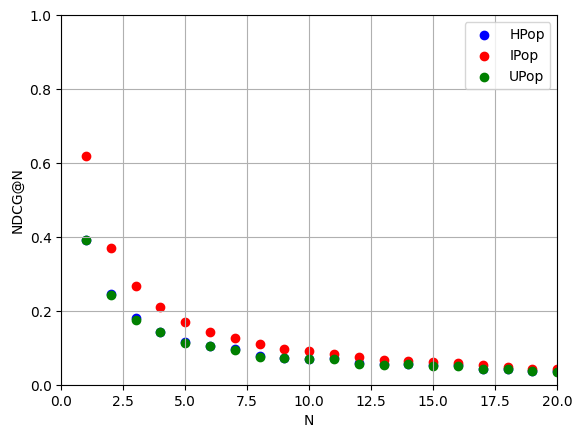

In [120]:
plt.scatter(NDCG_values['N'], NDCG_values['HPop'], label = 'HPop', color = 'blue')
plt.scatter(NDCG_values['N'], NDCG_values['IPop'], label = 'IPop', color = 'red')
plt.scatter(NDCG_values['N'], NDCG_values['UPop'], label = 'UPop', color = 'green')
plt.legend()
plt.xlabel('N')
plt.ylabel('NDCG@N')
plt.xlim(0,20)
plt.ylim(0,1)
plt.grid()

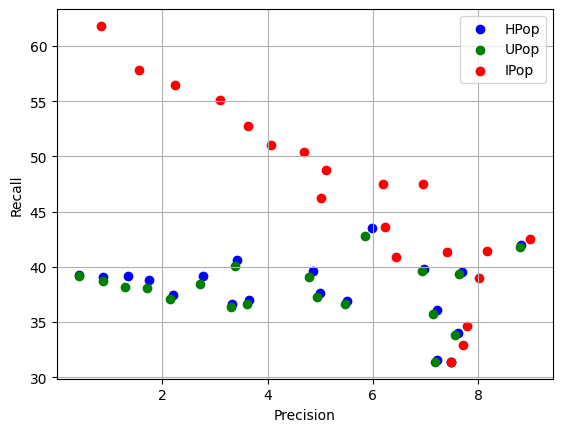

In [126]:
plt.scatter(Recall_values['HPop'], Precision_values['HPop'], label = 'HPop', color = 'blue', marker = 'o')
plt.scatter(Recall_values['UPop'], Precision_values['UPop'], label = 'UPop', color = 'green', marker = 'o')
plt.scatter(Recall_values['IPop'], Precision_values['IPop'], label = 'IPop', color = 'red', marker = 'o')
plt.legend()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()

In [53]:
dfs = main(ratings, movies, users, 0.9, 20)
hpop =dfs[0]
ipop = dfs[1]
upop = dfs[2]
hpop['NDCG'].mean(), ipop['NDCG'].mean(), upop['NDCG'].mean()

c:\Users\wypyc\Desktop\inżynierka\project\Cold-Start-Problem-in-RS\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[257   1 258   7   9  15 276 405 151  25 288 294  50 181 222 100 742 237
 111 117 118 121 125 127] to ta problematyczna array 2022.0 maksymalna ocena 50 id drugi sposob 50 PIERWSZU
6 klaster maksymalnego
[257   1 258   7   9  15 276 405 151  25 288 294  50 181 222 100 742 237
 111 117 118 121 125 127] to ta problematyczna array 2022.0 maksymalna ocena 50 id drugi sposob 50 PIERWSZU
6 klaster maksymalnego
[257   1 258   7   9  15 276 405 151  25 288 294  50 181 222 100 742 237
 111 117 118 121 125 127] to ta problematyczna array 2022.0 maksymalna ocena 50 id drugi sposob 50 PIERWSZU
6 klaster maksymalnego


(0.03889265761551604, 0.04952018598375229, 0.038107810909054816)

In [79]:
data = ratings
matrix = data.pivot(index='user_id', columns='movie_id', values='rating')
matrix = matrix.fillna(0)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in kfold.split(matrix.index.values):
    train_data = matrix[train_idx + 1]
    test_data = matrix[test_idx + 1]
    print(np.max(train_idx), np.max(test_idx))

942 940
942 941
941 942
942 936
942 939


In [43]:
upop = ff['NDCG'].mean()
upop

0.060043246382077274

In [40]:
ipop = ff['NDCG'].mean()
ipop

0.08851391807142293

In [37]:
hpop = ff['NDCG'].mean()
hpop

0.07218089224590386

<Axes: xlabel='Recall', ylabel='Precision'>

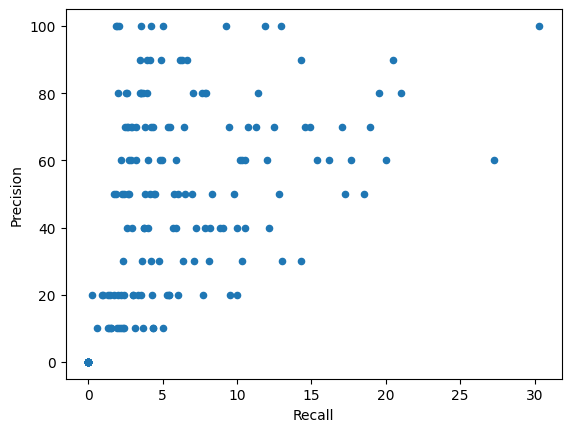

In [33]:
ff.plot(x = 'Recall', y = 'Precision', kind = 'scatter')

In [127]:
D = final_df[0]
D[D['NDCG'] > 0]['NDCG'].mean()

0.021716101056834608

<Axes: xlabel='Precision', ylabel='Recall'>

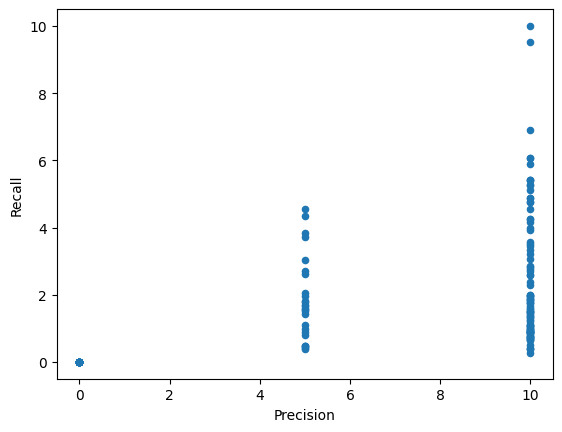

In [133]:
D = final_df[0]
D[D['Recall'] > 0]

D.plot(x = 'Precision', y = 'Recall', kind = 'scatter')

In [63]:
dfs = main(ratings, movies, users, 0.5, 20)
test = dfs[1]
train = dfs[2]
print(len(dfs))
res = dfs[0]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 78, cost: 1151.0
Run 1, iteration: 2/100, moves: 4, cost: 1151.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 63, cost: 1162.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 25, cost: 1186.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 351, cost: 1194.0
Run 4, iteration: 2/100, moves: 5, cost: 1194.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11, cost: 1218.0
Run 5, iteration: 2/100, moves: 1, cost: 1218.0
Best run was number 1
3


In [7]:
pivotek = ratings.pivot(index='user_id', columns='movie_id', values='rating')
pivotek
100000/(1682*943) * 100

6.304669364224531

In [ ]:

pivotek_test = ratings[ratings['user_id'].isin(test.index)]
pivotek_test.to_csv = 

In [61]:
kolumny_same_zera = (test == 0).all(axis=0)

# Policz ilość kolumn zawierających same zera
liczba_kolumn_same_zera = kolumny_same_zera.sum()

print("Liczba kolumn zawierających same zera:", liczba_kolumn_same_zera)


Liczba kolumn zawierających same zera: 237


In [18]:
def main_article():
    article_data = pd.read_csv(Path('..','..','res','data','article0.csv'))
    rating_matrix_article = article_data.pivot(index = 'user_id', columns='movie_id', values='rating')
    matrix_train = rating_matrix_article[rating_matrix_article.index.isin([1,2,3])]
    matrix_test = rating_matrix_article[rating_matrix_article.index.isin([4])]
    article_items_cl = article_data[article_data['user_id'].isin([1,2,3])]
    article_items_cl['cluster'] = 1
    article_users_cl = pd.DataFrame({'user_id':[1,2,3],
                                    'cluster':[1,1,1]})
    article_users_test_cl1 = pd.DataFrame({'user_id':[4],
                                    'cluster':[1]})
    final_matrix = nazwepozniej(matrix_test, matrix_train, 0.5, 20, rating_matrix_article, article_users_test_cl1, article_users_cl, article_items_cl)
    return(final_matrix)
article = main_article()

C:\Users\wypyc\AppData\Local\Temp\ipykernel_8844\4162523896.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_items_cl['cluster'] = 1
C:\Users\wypyc\AppData\Local\Temp\ipykernel_8844\2610122064.py:28: RuntimeWarning: divide by zero encountered in divide
  UIP = UP_dash / IP_dash
C:\Users\wypyc\AppData\Local\Temp\ipykernel_8844\2610122064.py:28: RuntimeWarning: invalid value encountered in divide
  UIP = UP_dash / IP_dash


ZeroDivisionError: division by zero

### do uruchomienia, jeśli chce się na sztywno clustry przypisać

In [19]:
us_te_cl = users_test.copy()
us_te_cl['cluster'] = 1

us_tr_cl = users_train.copy()
us_tr_cl['cluster'] = 1

it_cl = items_train.copy()
it_cl['cluster'] = 1

"""it_cl = article_items_cl
    it_cl"""

NameError: name 'users_test' is not defined

In [266]:
article_data = pd.read_csv(Path('..','..','res','data','article.csv'))
rating_matrix_article = article_data.pivot(index = 'user_id', columns='movie_id', values='rating')
matrix_train = rating_matrix_article[rating_matrix_article.index.isin([1,2,3])]
matrix_test = rating_matrix_article[rating_matrix_article.index.isin([4])]
train_numpy = matrix_train.to_numpy()
article_items_cl = article_data[article_data['user_id'].isin([1,2,3])]
article_items_cl['cluster'] = 1
article_users_cl = pd.DataFrame({'user_id':[1,2,3],
                                'cluster':[1,1,1]})
article_users_test_cl1 = pd.DataFrame({'user_id':[4],
                                'cluster':[1]})

C:\Users\wypyc\AppData\Local\Temp\ipykernel_17572\1047447764.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_items_cl['cluster'] = 1
